In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
from torch import nn
from torchsummary import summary
from torchmetrics import Accuracy, F1Score, ConfusionMatrix
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

from ultralytics import YOLO
from PIL import Image
import warnings

warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

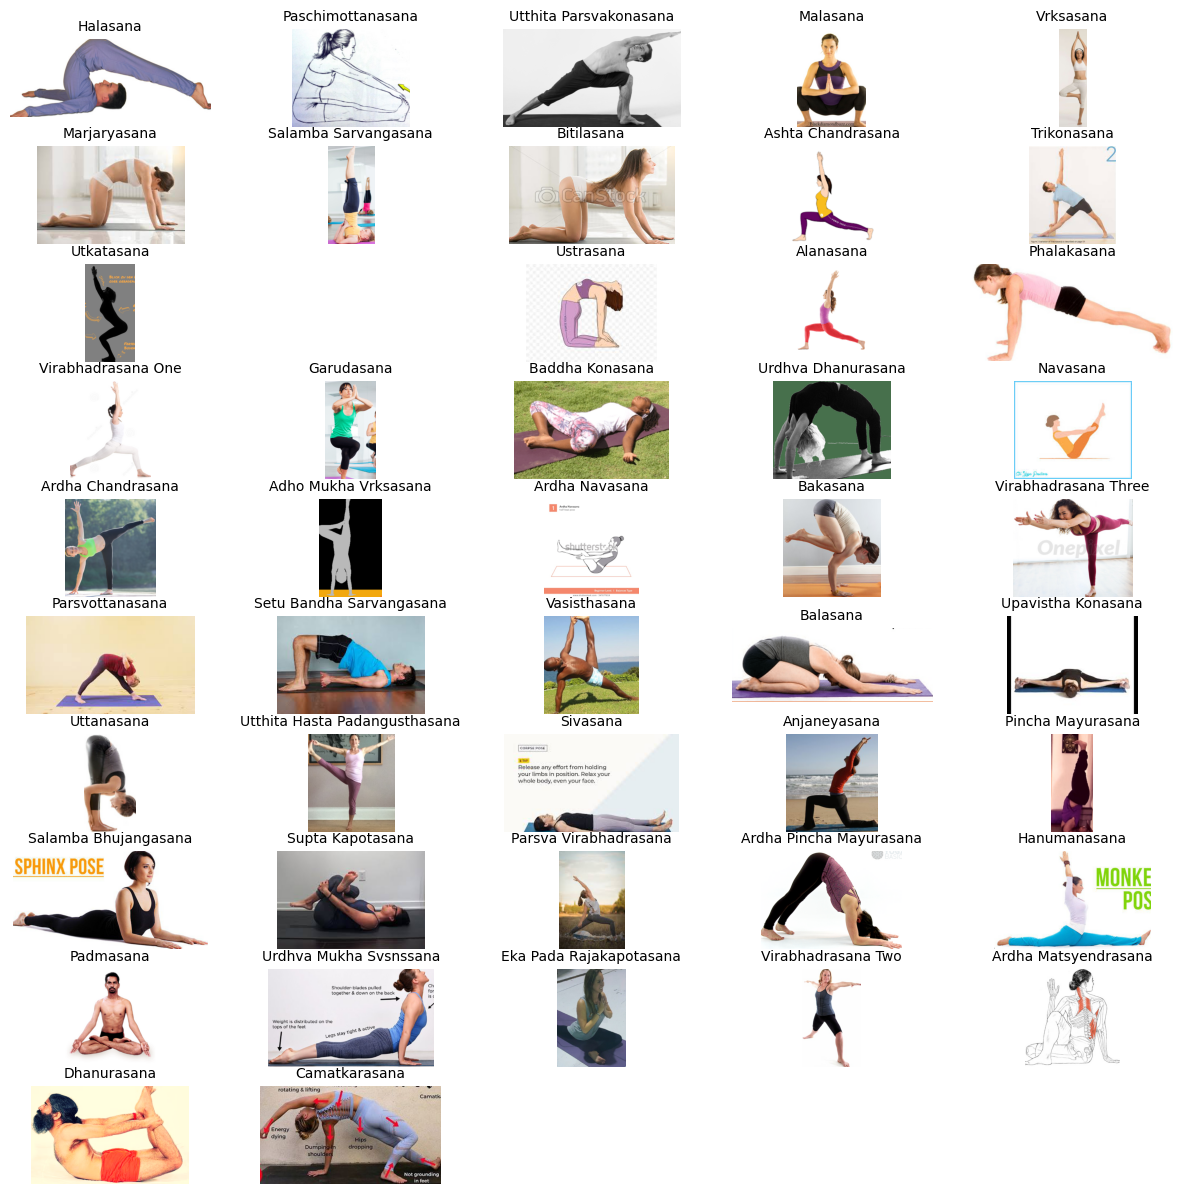

In [9]:
fig = plt.figure(figsize=(15,15))

image_folder = r"../yoga_kaggle_dataset"
for index, label in enumerate(os.listdir(image_folder)):
    if label == "Poses.json":
        continue
    
    image_list = os.listdir(os.path.join(image_folder,label))
    if len(image_list) == 0:
        os.remove(os.path.join(image_folder,label))
  
    
    img = random.choice(image_list)
    img = Image.open(os.path.join(image_folder,label,img))
    
    fig.add_subplot(10,5,index+1)
    plt.imshow(img)
    plt.title(label, fontsize=10)
    plt.axis("off")
plt.show()

In [10]:
model_yolo = YOLO("yolo11x-pose.pt")

100%|██████████| 113M/113M [00:03<00:00, 33.8MB/s] 


In [11]:
data = []

# Loop for each label
for label in os.listdir(image_folder):
    # Loop for each image per label
    if label == "Poses.json":
        continue
    image_dir = os.path.join(image_folder,label)
    print(image_dir)
    for img in os.listdir(image_dir):
        #image = os.path.join(image_folder,image_dir,img)
        image = os.path.join(image_dir,img)
        print(image)
        # Extracting keypoint with YOLOv8
        results = model_yolo.predict(image, boxes=False, verbose=False)
        for r in results:
            keypoints = r.keypoints.xyn.cpu().numpy()[0]
            keypoints = keypoints.reshape((1, keypoints.shape[0]*keypoints.shape[1]))[0].tolist()
            keypoints.append(image) #insert image path
            keypoints.append(label) #insert image label

            data.append(keypoints)

../yoga_kaggle_dataset/Halasana
../yoga_kaggle_dataset/Halasana/File50.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Halasana/File28.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Halasana/File14.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Halasana/File5.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Halasana/File18.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Halasana/File1.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Halasana/File7.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' 

libpng warning: iCCP: known incorrect sRGB profile


../yoga_kaggle_dataset/Baddha Konasana/File68.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Baddha Konasana/File29.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Baddha Konasana/File39.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Baddha Konasana/File16.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Baddha Konasana/File47.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Baddha Konasana/File37.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
../yoga_kaggle_dataset/Baddha Konasana/File52.png
WARNING ⚠️ 'boxes' is deprecated and will be removed in in the futur

In [12]:
print(len(data[0]))     # should be 51 if full (x, y, conf) for 17 keypoints
print(data[0])          # see structure

36
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4072294533252716, 0.43290865421295166, 0.4367550313472748, 0.38740551471710205, 0.08729282021522522, 0.80338054895401, 0.07965557277202606, 0.7347192168235779, '../yoga_kaggle_dataset/Halasana/File50.png', 'Halasana']


In [13]:
total_features = len(data[0])
df = pd.DataFrame(
    data=data, 
    columns=[f"x{i}" for i in range(total_features)]
    ).rename({
        "x34":"image_path", "x35":"label"
        }, axis=1)

df = df.dropna() #delete undetected pose 
df = df.iloc[:, 2:]

print(f"Total features {len(df.columns)-2}")
df.head()
df.to_csv("pose_features.csv", index=False)

Total features 32


In [14]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

classes_dict = {key:le.inverse_transform([key])[0] for key in range(len(df['label'].unique()))}
num_classes = len(classes_dict)

print(f"Total classes: {num_classes} ")
print(classes_dict)

Total classes: 46 
{0: 'Adho Mukha Vrksasana', 1: 'Alanasana', 2: 'Anjaneyasana', 3: 'Ardha Chandrasana', 4: 'Ardha Matsyendrasana', 5: 'Ardha Navasana', 6: 'Ardha Pincha Mayurasana', 7: 'Ashta Chandrasana', 8: 'Baddha Konasana', 9: 'Bakasana', 10: 'Balasana', 11: 'Bitilasana', 12: 'Camatkarasana', 13: 'Dhanurasana', 14: 'Eka Pada Rajakapotasana', 15: 'Garudasana', 16: 'Halasana', 17: 'Hanumanasana', 18: 'Malasana', 19: 'Marjaryasana', 20: 'Navasana', 21: 'Padmasana', 22: 'Parsva Virabhadrasana', 23: 'Parsvottanasana', 24: 'Paschimottanasana', 25: 'Phalakasana', 26: 'Pincha Mayurasana', 27: 'Salamba Bhujangasana', 28: 'Salamba Sarvangasana', 29: 'Setu Bandha Sarvangasana', 30: 'Sivasana', 31: 'Supta Kapotasana', 32: 'Trikonasana', 33: 'Upavistha Konasana', 34: 'Urdhva Dhanurasana', 35: 'Urdhva Mukha Svsnssana', 36: 'Ustrasana', 37: 'Utkatasana', 38: 'Uttanasana', 39: 'Utthita Hasta Padangusthasana', 40: 'Utthita Parsvakonasana', 41: 'Vasisthasana', 42: 'Virabhadrasana One', 43: 'Virabh

Split and Load Data

In [15]:
X = df.drop(["label","image_path"], axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

In [16]:
train_tensor = TensorDataset(X_train, y_train)
test_tensor = TensorDataset(X_test, y_test) 

In [17]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_tensor, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_tensor, batch_size=BATCH_SIZE, shuffle=False)

The Model

In [18]:
class YogaClassifier(nn.Module):
  def __init__(self, num_classes, input_length):
    super().__init__()
    self.layer1 = nn.Linear(in_features=input_length, out_features=64)
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.layer2 = nn.Linear(in_features=64, out_features=64)
    self.outlayer = nn.Linear(in_features=64, out_features=num_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.layer2(x)
    x = self.activation(x)
    x = self.outlayer(x)
    return x

input_length = X.shape[1]
model = YogaClassifier(num_classes=num_classes, input_length=input_length).to(device)
summary(model, input_size=(X.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 2643, 64]           2,112
              ReLU-2             [-1, 2643, 64]               0
           Dropout-3             [-1, 2643, 64]               0
            Linear-4             [-1, 2643, 64]           4,160
              ReLU-5             [-1, 2643, 64]               0
            Linear-6             [-1, 2643, 46]           2,990
Total params: 9,262
Trainable params: 9,262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.32
Forward/backward pass size (MB): 7.38
Params size (MB): 0.04
Estimated Total Size (MB): 7.74
----------------------------------------------------------------


Training Loop

In [19]:
accuracy_score = Accuracy(task="multiclass", num_classes=num_classes).to(device)
f1_score = F1Score(task="multiclass", num_classes=num_classes).to(device)

def train_step(model, dataloader, optimizer, loss_fn):
    model.train()
    train_loss, train_acc, train_f1 = 0, 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        #loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #accuracy
        logits = torch.softmax(y_pred, dim=1)
        class_prediction = torch.argmax(logits, dim=1)
        acc = accuracy_score(class_prediction, y)
        f1 = f1_score(class_prediction, y)
        train_acc += acc.item()
        train_f1 += f1.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    train_f1 /= len(dataloader)

    return train_loss, train_acc, train_f1

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc, test_f1 = 0, 0, 0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            #loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            #accuracy
            logits = torch.softmax(y_pred, dim=1)
            class_prediction = torch.argmax(logits, dim=1)
            acc = accuracy_score(class_prediction, y)
            f1 = f1_score(class_prediction, y)
            test_acc += acc.item()
            test_f1 += f1.item()

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    test_f1 /= len(dataloader)
    return test_loss, test_acc, test_f1

In [20]:
def train_loop(model, trainloader, testloader, optimizer, loss_fn, epochs, verbose=True):
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "test_loss": [],
        "test_accuracy": [],
        "test_f1": [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_f1 = train_step(
            model=model,
            dataloader=trainloader,
            optimizer=optimizer,
            loss_fn=loss_fn
        )

        test_loss, test_acc, test_f1 = test_step(
            model=model,
            dataloader=testloader,
            loss_fn=loss_fn
        )
       
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_acc)
        history['test_f1'].append(test_f1)
    
        # Checkpoint
        best = max(history['test_accuracy'])
        best_epoch = history['test_accuracy'].index(best) 
   
        if test_acc < best:
            status = f"Accuracy not improved from epoch {best_epoch}"
        else: 
            status = f"Accuracy improved, saving weight....."
            torch.save(model.state_dict(), 'best.pth')

        if verbose:
            print(f"Epoch {epoch}")
            print(f"train loss: {train_loss} | test loss: {test_loss}")
            print(f"train accuracy: {train_acc} | test accuracy: {test_acc}")
            print(f"train f1: {train_f1} | test f1: {test_f1}")
            print(status)
            print("-------------------------------------------------")

    print(f"Best accuracy on epoch: {best_epoch}, accuracy: {best}")
    return history, best_epoch

Plot Result

In [21]:
def plot_result(train, test, ax, title, best_epoch):
    ax.plot(train, label='train')
    ax.plot(test, label='test')
    ax.axvline(x=best_epoch, color='blue', linestyle='--')
    ax.set_title(title)
    ax.legend()

Training Process

In [23]:
optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())
loss_fn = nn.CrossEntropyLoss()
epochs = 100

result, best = train_loop(
      model=model,
      trainloader=train_dataloader,
      testloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=epochs,
      verbose=True
      )

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0
train loss: 1.8753644069035849 | test loss: 1.9761962360805936
train accuracy: 0.4574166667461395 | test accuracy: 0.43981481591860455
train f1: 0.4574166667461395 | test f1: 0.43981481591860455
Accuracy improved, saving weight.....
-------------------------------------------------
Epoch 1
train loss: 1.853723030090332 | test loss: 1.9680535528394911
train accuracy: 0.4524166667461395 | test accuracy: 0.4309413582086563
train f1: 0.4524166667461395 | test f1: 0.4309413582086563
Accuracy not improved from epoch 0
-------------------------------------------------
Epoch 2
train loss: 1.8295606565475464 | test loss: 1.9163039260440402
train accuracy: 0.4794166668256124 | test accuracy: 0.4502314825852712
train f1: 0.4794166668256124 | test f1: 0.4502314825852712
Accuracy improved, saving weight.....
-------------------------------------------------
Epoch 3
train loss: 1.8018567323684693 | test loss: 1.9161033630371094
train accuracy: 0.4703333334128062 | test accuracy: 0.4745370381

Result Analysis

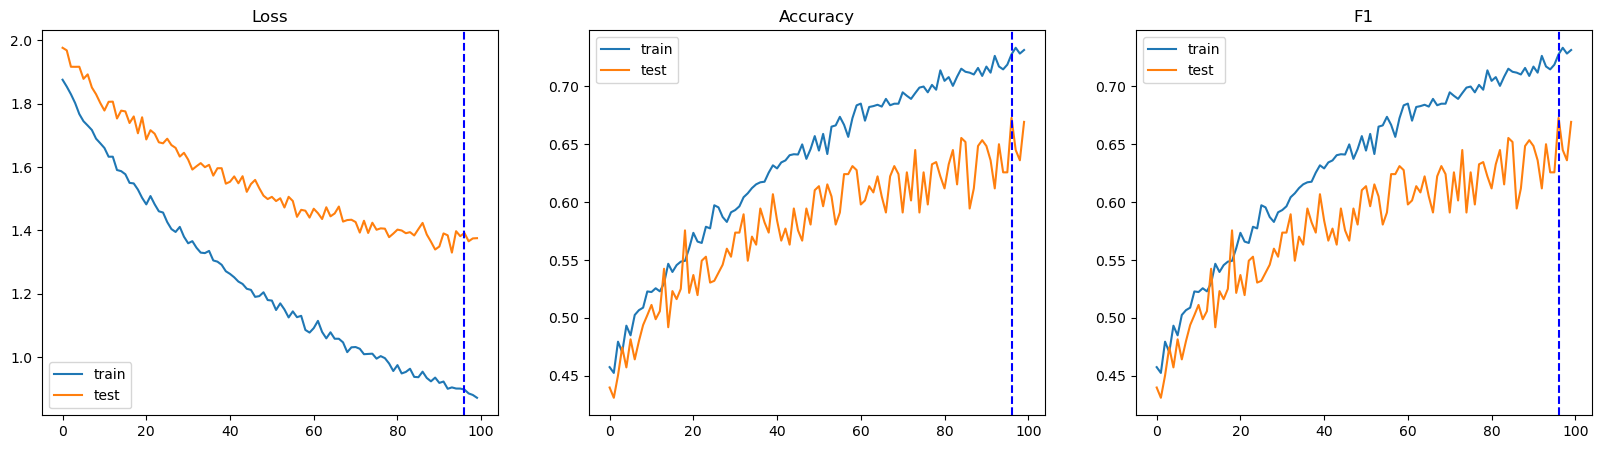

In [24]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,5))
plot_result(result['train_loss'], result['test_loss'], ax1, "Loss", best)
plot_result(result['train_accuracy'], result['test_accuracy'], ax2, "Accuracy", best)
plot_result(result['train_f1'], result['test_f1'], ax3, "F1", best)
plt.show()

In [25]:
def model_eval(model, dataloader):
    y_preds = []
    y_true = []
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_logit = model(X)
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            y_preds.append(y_pred)
            y_true.append(y)

    y_pred = torch.cat(y_preds).cpu().numpy()
    y_test = torch.cat(y_true).cpu().numpy()

    report = classification_report(y_pred, y_test)
    cm = confusion_matrix(y_pred, y_test)

    return report, cm

In [26]:
model_pose = YogaClassifier(num_classes=num_classes, input_length=input_length).to(device)
model_pose.load_state_dict(torch.load(f="best.pth"))

<All keys matched successfully>

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.67      0.40      0.50         5
           2       0.00      0.00      0.00         0
           3       0.71      0.62      0.67         8

    accuracy                           0.67        21
   macro avg       0.54      0.47      0.50        21
weighted avg       0.73      0.67      0.69        21



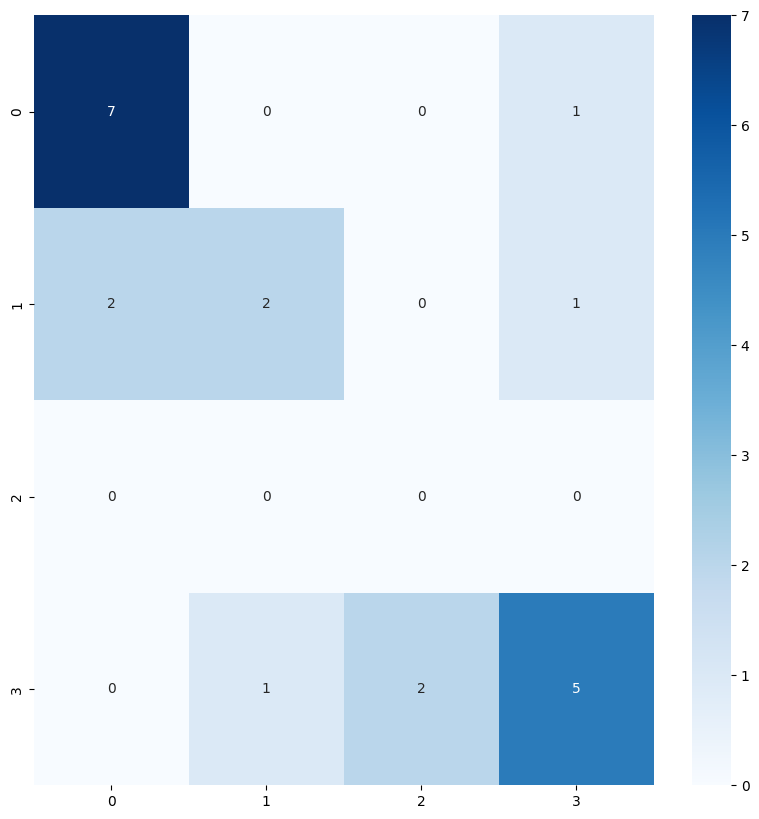

In [35]:
cls_report, cls_cm = model_eval(model, test_dataloader)

print(cls_report)

plt.figure(figsize=(10,10))
sns.heatmap(cls_cm, annot=True, fmt='g', cmap='Blues')
plt.show()

In [27]:
def make_prediction(image, true_label):
    results = model_yolo.predict(image, boxes=False, verbose=False)
    for r in results:
        im_array = r.plot(boxes=False)  # plot a BGR numpy array of predictions
        keypoints = r.keypoints.xyn.cpu().numpy()[0]
        keypoints = keypoints.reshape((1, keypoints.shape[0]*keypoints.shape[1]))[0].tolist()

    #Prediction
    model_pose.cpu()
    model_pose.eval()
    with torch.inference_mode():
        logit = model_pose(torch.tensor(keypoints[2:]))
        pred = torch.softmax(logit, dim=0).argmax(dim=0).item()
        prediction = classes_dict[pred]
    
    # if prediciton is correct, title color will be green.
    if prediction == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.imshow(im_array[..., ::-1])
    plt.title(f"prediction:{prediction}\ntrue label:{true_label}", color=color)
    plt.show()

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


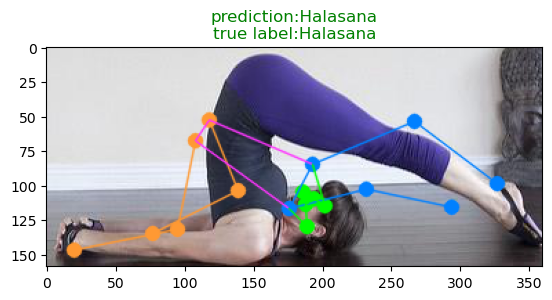

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


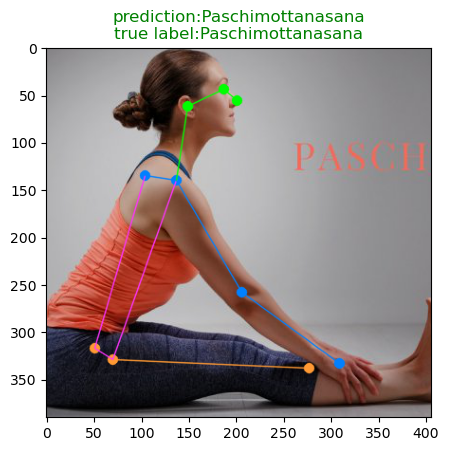

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


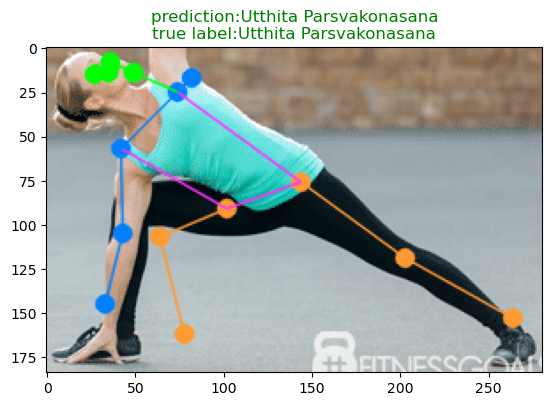

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


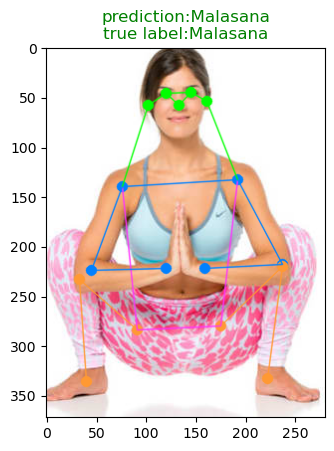

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


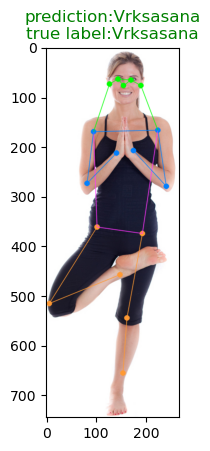

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


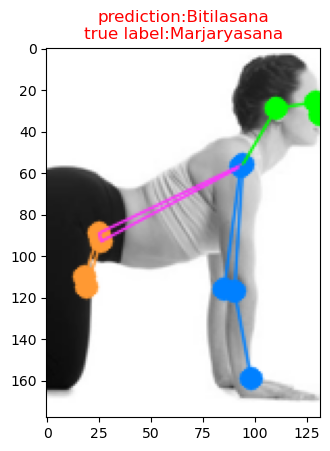

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


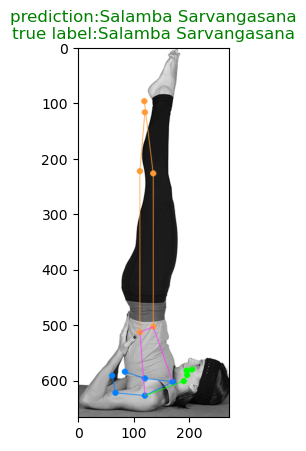

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


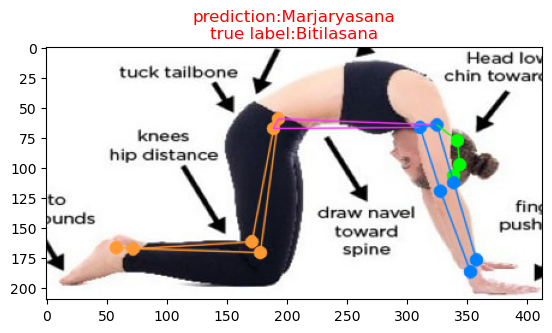

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


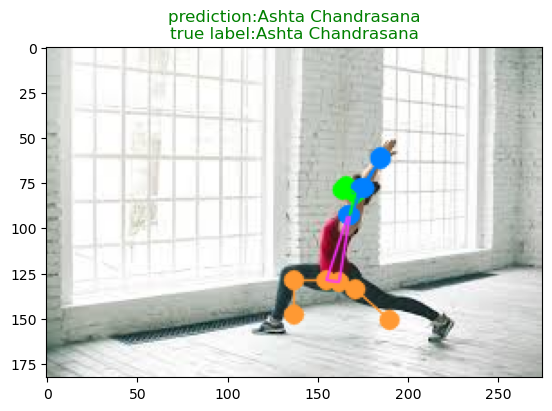

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


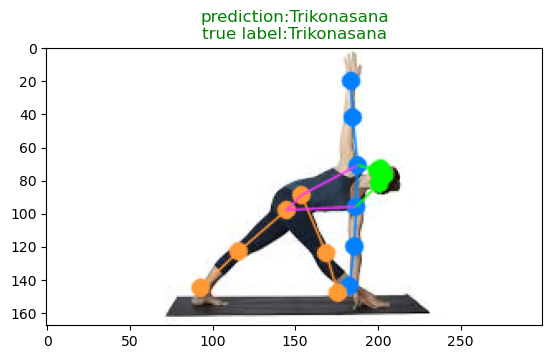

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


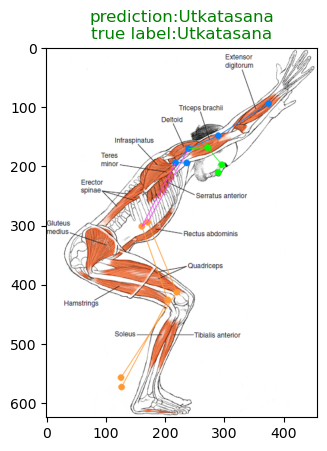

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


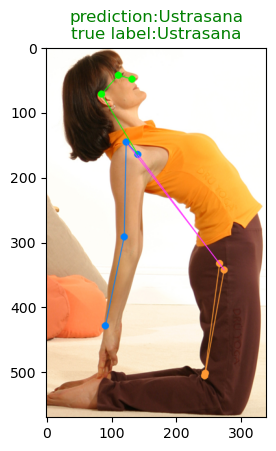

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


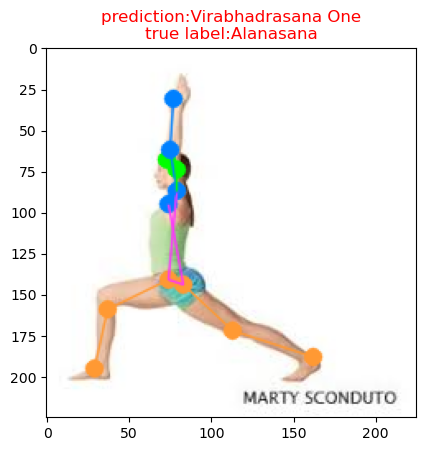

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


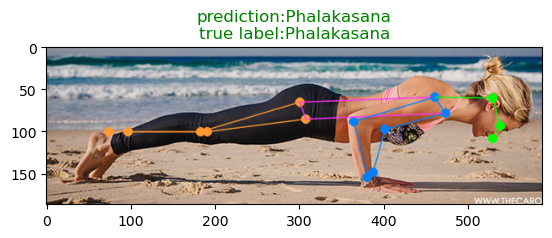

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


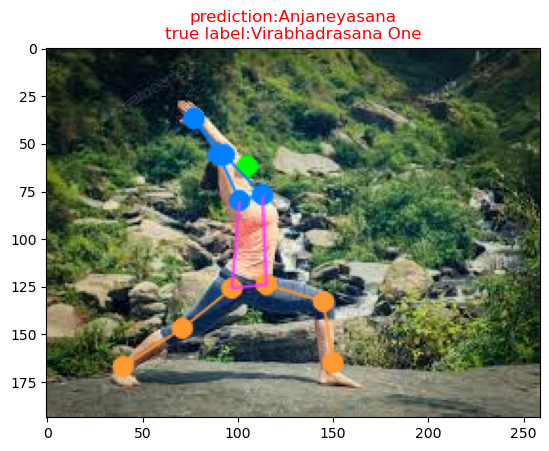

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


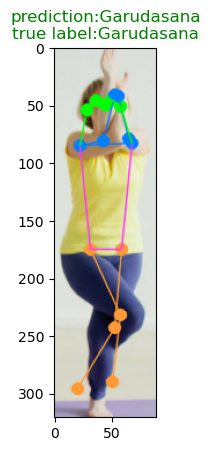

WARNING ⚠️ 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x0 and 32x64)

In [30]:
image_folder = r"../yoga_kaggle_dataset"
for label in os.listdir(image_folder):
    if label == 'Poses.json':
        continue
    
    true_label = label 
    
    image_list = os.listdir(os.path.join(image_folder,label))
    if len(image_list) == 0:
        continue
  
    img = random.choice(image_list)
    img = os.path.join(image_folder,label,img)
    make_prediction(img, true_label)